In [ ]:
import cv2
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR
import numpy as np
import statistics as stat
import pandas as pd
from datetime import datetime
import constants as c
from collections import Counter
from scipy import stats

In [ ]:
ocr = PaddleOCR(lang='en',  use_angle_cls=True)

In [483]:
def final_value(list_value):
  if list_value:
    m = round(np.mean(list_value),1)
    mode = round(stat.mode((list_value)),1)
    if abs(m - mode)> 5:
      return None
    return m
  return None

def drop_outliers(angles):
  if angles:
      z = np.abs(stats.zscore(angles))
      #print(z)
      if np.all(np.isnan(z)):
          return angles
      new_angles = []
      for i in range(len(angles)):
          if z[i]<1.3 and z[i]> 0.3:
              new_angles.append(angles[i])
      return new_angles

def corr_scala(value, scale):
    if value:
        aux = value%scale
        value = value - aux
        if aux >= scale/2:
            value = value + scale
            
    return value

def select_result_OCR(result_ocr, inst):
    list_OCR  = []
    for linha in result_ocr:
        try:
            number = int(linha[1][0])
        except:
            number = None
        if number!= None and not number%c.scala_table_T27[inst]:
            list_OCR.append((number, (linha[0][0][1] + linha[0][3][1])/2))
    
    list_OCR_validos = []
    idx_max = 0
    max = -1
    for i in range(len(list_OCR)-1):
        aux1 = []
        
        
        
        for j in range(i+1,len(list_OCR)):
            
            calc = round((list_OCR[j][1] - list_OCR[i][1])*c.scala_table_T27[inst]/c.dist_scala_T27,0) + list_OCR[j][0]
            calc = corr_scala(calc, c.scala_table_T27[inst])
            
            if list_OCR[i][0]== calc:
                aux1.append(list_OCR[j])
        if len(aux1):
            aux1.append(list_OCR[i])
            
            if len(aux1) >= max:
                max = len(aux1)
                idx_max = i
        list_OCR_validos.append(aux1)
    if list_OCR_validos:
        return list_OCR_validos[idx_max]
    else: 
        return None

def calc_ind(list_OCR_validos, inst, ref):
    list_result = []
    value = None
    if list_OCR_validos:
        for item in list_OCR_validos:
            result = round(item[0] + (item[1] - ref)*c.scala_table_T27[inst]/c.dist_scala_T27,0)
            list_result.append(result)
        list_result = drop_outliers(list_result)
        value = final_value(list_result)
        value = corr_scala(value, c.scala_voo_T27[inst])
        
    return value
    

def processing_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    M = np.ones(image.shape, dtype="uint8") * 35
    image = cv2.subtract(image, M)
    image = cv2.bitwise_not(image)
    
    return image

In [ ]:
directory = '../frames/T27/'
result = []
df2_result = []
df3_result = []
ini = 0
quant = 15



for i in range(ini,quant):
    print("\n\n#################################### ", i, "####################################\n\n ")
    
    
    row_result = []
    
    for key, param in c.inst_voo_T27.items():
        #print(key)
        path = directory + key +'/'+ key +'_' + str(i) +'.png'
        image = cv2.imread(path)
        image = processing_image(image)
        ref = image.shape[0]/2
        list_ocr = ocr.ocr(image, cls=False)
        #for line in list_ocr:
            #print(line)
        list_ocr = select_result_OCR(list_ocr, key)
        number = calc_ind(list_ocr, key, ref)
        row_result.append(number)
        


    result.append(row_result)

df = pd.DataFrame(result, columns=["SPEED","ALT"])

path = 'csv/T27/T27_VOO_' + datetime.today().strftime('%m%d_%H%M') + '.csv'
df.to_csv(path, index= False)


In [11]:
def moving_average(dataframe, n):
  df = dataframe.copy()
  half_n = int(n/2)
  idx = half_n + 1
  idx_max = len(dataframe) - half_n
  result = []
  for i in range(0,idx):
    result.append(round(df[0:i+half_n+1].mean(),1))
  for i in range(idx,len(df)):
    result.append(round(df[i-half_n:i+half_n+1].mean(),1))

  res = pd.DataFrame(result,columns=df.columns.tolist())

  return res

def filter(dataframe, moving_average):
  df = dataframe.copy()
  dif = round(abs(df - moving_average),1)
  for column in dif:
    s = 15*c.scala_voo_T27[column]
    idx = dif[column][dif[column] > s].index.tolist()
    for i in idx:
      #print(column, i)
      df[column][i] = np.nan
      
  return df
      
def drop_outliers(df):
    df1 = pd.DataFrame()
    for column in df:
        value = df[column].tolist()
        
        limit = c.scala_voo_T27[column]
        for i in range(1,len(value)):
            if value[i]!= None and value[i-1]!= None:
                if abs(value[i] - value[i-1]) > 5*limit:
                    #print(column, i)
                    value[i] = None
                    #print(i)
        
        df1[column] = value
    return df1

In [17]:
path = 'csv/T27/T27_VOO_1028_0501.csv'
df_sp = pd.read_csv(path)
m = moving_average(df_sp,3)
df_sp = filter(df_sp,m)
df_sp = drop_outliers(df_sp)

path = 'dados_sim/T27.csv'
df = pd.read_csv(path)
df = df.drop(columns=["Frame","Unnamed: 10"])
df = df.round(1)
df1 = df[1:]
df1

,NG,NH,T5,TRQ,OIL_PRESS,OIL_TEMP,FF,SPEED,ALT
1,97.7,115.2,690.7,1004.4,84.8,60.5,275.6,107.5,11985.3
2,96.5,116.5,682.8,954.9,84.7,60.5,273.2,107.4,11990.3
3,95.7,118.4,677.8,922.3,84.7,60.5,270.9,107.3,11993.4
4,95.0,119.1,673.2,888.2,84.7,60.5,268.9,107.2,11996.2
5,94.3,118.5,668.8,857.1,84.6,60.5,266.1,107.0,11998.8
...,...,...,...,...,...,...,...,...,...
15416,84.7,90.4,605.7,567.9,81.5,57.6,257.5,101.4,7421.6
15417,84.7,90.4,605.7,568.0,81.5,57.6,257.5,101.6,7419.5
15418,84.7,90.4,605.7,568.0,81.5,57.6,257.5,101.8,7417.5
15419,84.7,90.4,605.7,568.1,81.5,57.6,257.5,102.0,7415.4


In [18]:

df_compare = pd.DataFrame()
df_compare['SPEED_Real'] = df1['SPEED']
df_compare["SPEED"] = df_sp["SPEED"]
df_compare['ALT_Real'] = df1['ALT']
df_compare["ALT"] = df_sp["ALT"]
df_compare

,SPEED_Real,SPEED,ALT_Real,ALT
1,107.5,113.0,11985.3,11660.0
2,107.4,113.0,11990.3,11660.0
3,107.3,113.0,11993.4,11660.0
4,107.2,NaN,11996.2,11660.0
5,107.0,NaN,11998.8,11660.0
...,...,...,...,...
15416,101.4,NaN,7421.6,NaN
15417,101.6,NaN,7419.5,NaN
15418,101.8,NaN,7417.5,NaN
15419,102.0,NaN,7415.4,NaN


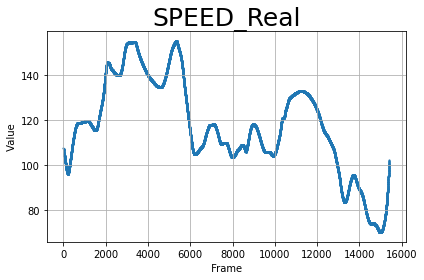

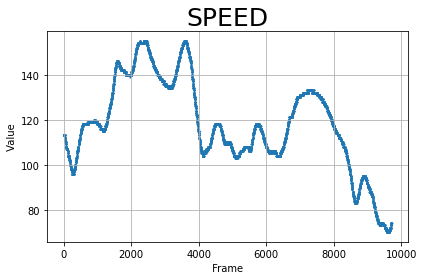

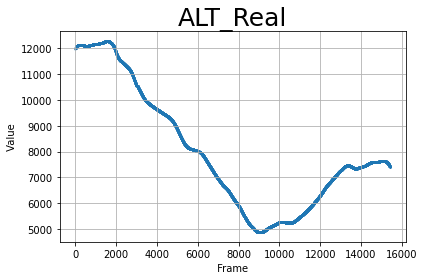

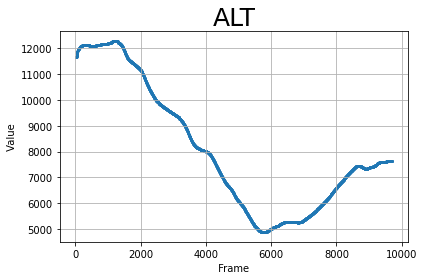

In [19]:
df = df_compare.copy()
for column in df:
  inst = str(column)
  
  fig, ax = plt.subplots()

  x = df.index.tolist()
  y = df[column].values.tolist()
  ax.scatter(x,y, marker=".", s =5)
  plt.grid ()
  title = column
  plt.title(title,fontsize=25)
  plt.xlabel ( ' Frame ')
  plt.ylabel ( ' Value ')
  plt.tight_layout ()
  plt.show()